### Imports

In [1]:
%matplotlib widget
import os
import sys
import time
sys.path.append(os.path.abspath('..'))

from linetimer import CodeTimer
import matplotlib.pyplot as plt
import nibabel
from nibabel import processing, nifti1, affines
import numpy as np
from scipy.ndimage import median_filter
from skimage.metrics import mean_squared_error, normalized_root_mse

import MedianFilter


### GPU Initialization

In [2]:
GPUBackend='OpenCL'
gpu_name = 'gfx1030'

if GPUBackend=='OpenCL':
    MedianFilter.InitOpenCL(gpu_name)
elif GPUBackend=='CUDA':
    MedianFilter.InitCUDA(gpu_name)
else:
    MedianFilter.InitMetal(gpu_name)

gfx1030
Selecting device:  gfx1030


c:\Users\acoreas\miniconda3\envs\bbl_dev\lib\site-packages\pyopencl\__init__.py:270: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


### Load Input Data

In [3]:
fname = 'D:/acoreas/BabelBrain_Test_Data/SDR_0p55/T1W.nii.gz'
base_name,_ = os.path.splitext(os.path.splitext(fname)[0])
nifti=nibabel.load(fname)
data=np.ascontiguousarray(nifti.get_fdata().astype(np.uint8))

### Determine Output Data Resolution

In [4]:
spatial_steps = {
    'low_res': 0.919, # 6 PPW, 200 kHz
    'medium_res': 0.163, # 9 PPW, 750 kHz
    'high_res': 0.092, # 12 PPW, 1000 kHz
}

spatial_step = spatial_steps['low_res']

# Calculate new affine
T1W_affine_upscaled = affines.rescale_affine(nifti.affine.copy(),nifti.shape,spatial_step,(int(nifti.shape[0]//spatial_step)+1,int(nifti.shape[1]//spatial_step)+1,int(nifti.shape[2]//spatial_step)+1))

# output dimensions
output_data = np.zeros((int(data.shape[0]//spatial_step)+1,int(data.shape[1]//spatial_step)+1,int(data.shape[2]//spatial_step)+1),dtype=np.uint8)
output_nifti = nifti1.Nifti1Image(output_data,T1W_affine_upscaled)

### Run Resample Step

In [5]:
resampled_fname = base_name + f"_{spatial_step}.nii.gz"
if os.path.exists(resampled_fname):
    resampled_data = np.ascontiguousarray(nibabel.load(resampled_fname).get_fdata().astype(np.uint8))
else:
    resampled_nifti = processing.resample_from_to(nifti,output_nifti,mode='constant',order=0,cval=data.min()) # Truth method
    nibabel.save(resampled_nifti,resampled_fname)
    resampled_data=np.ascontiguousarray(resampled_nifti.get_fdata().astype(np.uint8))

### Run Median Filter Step

In [6]:
with CodeTimer("GPU Median Filter", unit="s"):
    data_mf_gpu=MedianFilter.MedianFilter(resampled_data,7,GPUBackend=GPUBackend)

with CodeTimer("CPU Median Filter", unit="s"):
    mf_truth_fname = base_name + f"_mf_truth_{spatial_step}.nii.gz"
    if os.path.exists(mf_truth_fname):
        data_mf_cpu = nibabel.load(mf_truth_fname).get_fdata()
    else:
        data_mf_cpu=median_filter(resampled_data,7)
        nifti_mf_cpu = nibabel.Nifti1Image(data_mf_cpu,T1W_affine_upscaled)
        nibabel.save(nifti_mf_cpu,mf_truth_fname)

if data_mf_gpu.size != data_mf_cpu.size:
    print(f"Array sizes don't match: {data_mf_gpu.size} vs {data_mf_cpu.size}")
if data_mf_gpu.size == 0:
    print("Arrays are empty")

Starting Median Filter
Total points: 15957405
Working on slices 0 to 279 out of 279
Code block 'GPU Median Filter' took: 1.31838 s
Code block 'CPU Median Filter' took: 0.29745 s


### Plot Data

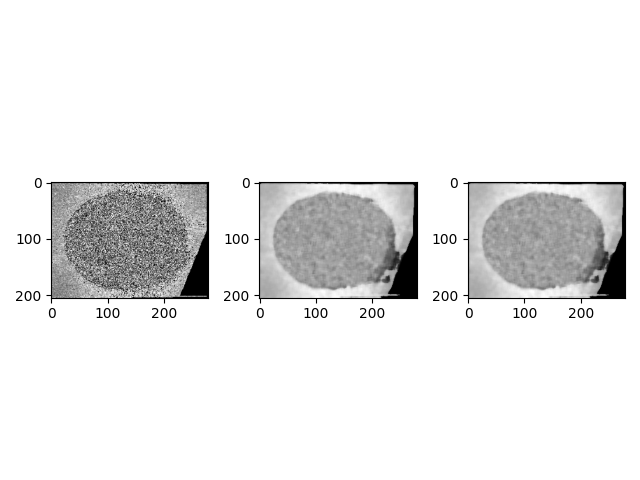

In [7]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(resampled_data[:,:,resampled_data.shape[2]//2], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(data_mf_cpu[:,:,data_mf_cpu.shape[2]//2], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(data_mf_gpu[:,:,data_mf_gpu.shape[2]//2], cmap='gray')
plt.tight_layout()

### Check Output Data Matches Truth Data

In [8]:
data_match = np.all(data_mf_cpu==data_mf_gpu)
print(f"Data matches? {data_match}")

if not data_match:
    matches = abs(data_mf_gpu - data_mf_cpu) < 1e-6
    matches_count = len(matches[matches==True])

    dice_coeff = 2 * matches_count / (data_mf_cpu.size + data_mf_gpu.size)

    print(f"Dice Coefficient: {dice_coeff}")

    mse = mean_squared_error(data_mf_cpu,data_mf_gpu)
    print(f"Mean square error: {mse}")

Data matches? True


### Plot Differences Between Output and Truth

Difference Histogram
-0.50 to -0.40: 0
-0.40 to -0.30: 0
-0.30 to -0.20: 0
-0.20 to -0.10: 0
-0.10 to 0.00: 0
0.00 to 0.10: 15957405
0.10 to 0.20: 0
0.20 to 0.30: 0
0.30 to 0.40: 0
0.40 to 0.50: 0


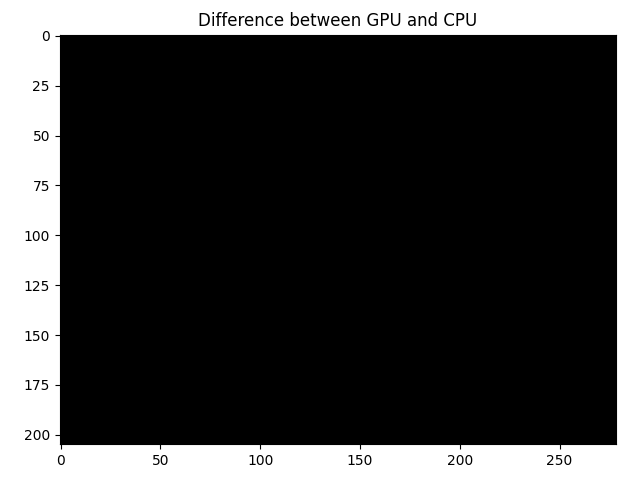

In [9]:
diffs = abs(data_mf_gpu - data_mf_cpu)

plt.figure()
plt.imshow(diffs[:,:,diffs.shape[2]//2], cmap='gray')
plt.title('Difference between GPU and CPU')
plt.tight_layout()

hist,bins = np.histogram(diffs)
print(f"Difference Histogram")
for bin in range(len(bins)-1):
    print(f"{bins[bin]:.2f} to {bins[bin+1]:.2f}: {hist[bin]}")